# Un primer acercamineto a Pytorch

Pytorch es un framework libre y de open source para la implementación de modelos de Deep Learning. Fue desarrollado principalmenete por el laboratorio de investigación de inteligencia artificial de Facebook (FAIR) y fue liberado en octubre del 2016. Ha sido ampliamente usado en Visión por Computadora, Procesamiento de Lenguaje Natural, Reinforcement Learning, entre otros temas. 

Entre las características que tiene Pytorch, destacan las siguientes: 

   * El uso de ``torch``, que es una biblioteca optimizada para el computo tensorial, similar a Numpy, basado en el lenguaje de programación Lua. La gran ventaja de esta biblioteca es que puede ser operada desde CUDA para hacer uso de un GPU Nvidia. 
   
   * El uso explícito de la diferenciación automática. Es posible dar seguimiento a las operaciones numéricas realizadas y después calcular los gradientes en cada paso, esta es una herraminta muy útil en el proceso de *Backward propagation* en el entrenaminto de redes neuronales.
   
En su sitio web ofrecen más información del framework, también hay foros de discusión, tutoriales entre otras cosas: 
https://pytorch.org. Además en la página web da la opción de descargar el libro *DEEP LEARNING WITH PYTORCH* de forma gratiuta, la dirección la puedes encontar [aquí](https://pytorch.org/deep-learning-with-pytorch). El libro permite aprender las partes escenciales del framework y concepetos relacionados con Deep Learning.

Ahora usaremos pytorch para hacer un clasificador para el conjuto de imágenes CIFAR10. Nos basaremos en el tutorial que puede encontrar [aquí](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

Antes de empezar, será necesario introducir los siguientes módulos:

* ``torch``: puede encontrar ejemplos del uso de torch en el notebook [pytorch_basics](pytorch_basics.ipynb).
* ``torch.nn``: consite de los modelos y funciones usados en la red neuronal, puede encontrar ejemplos del módulo en el notebook [pytorch_nn](pytorch_nn.ipynb).
* ``torchvison``: consite datasets populares, arquitecturas populares y transformaciones para visión por computadora
(``transforms``).

Será necesario instalar las siguientes bibliotecas: 

* torch
* torchvision
* tqdm

In [1]:
import torch
import torchvision 
import torchvision.transforms as t

### CPU vs GPU

Pytorch permite hacer uso del CPU de forma predeterminda o GPU, si este existe y el usario selecciona la opción de usarlo. Para hacer uso del GPU sólo es necesario ejecutar la instrucción siguiente:

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"

print(device)

cpu


**Nota:** Si no se tiene CPU se dejará indicado que se usará el CPU. Si no se quiere usar el GPU basta con omitir la instrucción anterior salvo la indicación ``device = "cpu"``.

## Preparación y Normalización de datos 

La siguiente instrucción corresponde al almacenaminto y normalización de los datos. Note que el conjunto de datos proviene de ``torchvision.datasets`` y esta biblioteca, por defecto, ya tiene separados los datos de entrenamiento y prueba, basta con indicarlo.

In [3]:
transform = t.Compose([t.ToTensor(), 
                      t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)


Failed download. Trying https -> http instead. Downloading http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz to ./data/cifar-10-python.tar.gz


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


En la siguiente instrucción, se procede a separar los datos de entrenamiento en los datos que usaremos para entrenar y para validar.

In [4]:
import numpy as np

valid_size = 0.2 # parte para validar
n = len(trainset)
indices = list(range(n))
np.random.shuffle(indices) # revolvemos los indices
split = int(np.floor(valid_size * n)) 
train_idx, valid_idx = indices[split:], indices[:split] # seprarmos los indices

train_set = torch.utils.data.Subset(trainset, train_idx) # tomamos un subconjunto de acuerdo a los indices
val_set = torch.utils.data.Subset(trainset, valid_idx)
n_train = len(train_set)
n_val = len(val_set) 

Ahora le damos una estructura a los datos, es decir, los preparemos para el entrenamiento, indicaremos el ``batch_size``, no estarán ordenados. Para ello creamos un objeto del tipo ``DataLoader`` a paritr de un conjunto dado  que nos permitirá hacer lo anteriormente mencionado. Puede consultar más información sobre ``DataLoader`` [aquí](https://pytorch.org/docs/stable/data.html).

In [5]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(testset, batch_size=len(testset), 
                                        shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
         'ship', 'truck']

## Exploración y análisis del Dataset

Veamos las dimensiones de las muestras.

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

In [7]:
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 32, 32])
torch.Size([32])


Veamos como es una muestra del datast.

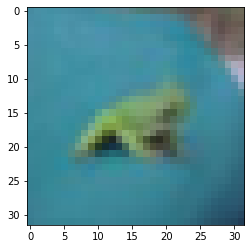

class:  frog


In [8]:

import matplotlib.pyplot as plt
import numpy as np

def show_image(img):
    np_img = img.numpy()
    np_img = np.copy(np_img)
    np_img /= 2
    np_img += 0.5
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# show image

index = 10
show_image(torchvision.utils.make_grid(images[index]))
print('class: ', classes[labels[index]])

## Definición de la arquitectura de la red neuronal

Para este conjunto de datos usaremos una red convolucional. Para ello ocuparemos la clase ``Conv2d``del módulo
torch.nn. Como en otros frameworks es necesario definir la estructura de la capa convolucional, al definir la capa es necesario proporcionar los siguientes paramétros: 

* ``in_channels (int)``: Número de canales que tiene el tensor de entrada. 
* ``out_channels (int)``: Número de canales producidos por la convolusión.
* ``kernel_size (int or tuple)``: Tamaño del kernel.
* ``stride (int or tuple, optional)``: Stride de la convolución. Por defecto: 1.
* ``padding (int or tuple, optional)``: Padding . Por defecto: 0.
* ``padding_mode (string, optional)``: 'zeros', 'reflect', 'replicate' or 'circular'. Por defecto: 'zeros'.
* ``dilation (int or tuple, optional)``: Espaciado entre los elementos del kernel. Por defecto: 1.
* ``groups (int, optional)``:  Número de conecciones bloqueadas de los caneles de entrada a los de salida. Por defecto: 1.
* ``bias (bool, optional)``: Agrega bias. Default: True

Puede consultarse la documentación de ``Conv2d`` [aquí](https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html).

En la transición de capas convolucionales ocuparemos ``MaxPool2d`` del módulo ``nn.torch``, tiene los siguientes parámetros: 

* ``kernel_size``: El tamaño de la ventana donde se aplicará el max. 

* ``stride``: El stride de la ventana. Por defecto es el kernel_size.

* ``padding``: implicit zero padding to be added on both sides.

* ``dilation``: un parámetro que controla el stride de elementos en la ventana. 

* ``return_indices``: Es un booleno, si es ``True``, regresa el máximo de indices con las salidas. 

* ``ceil_mode``:  Es un booleno, si es ``True``, usa la función piso en lugar de la techo para calcular el shape de la salida.

Puede consultarse la documentación de ``MaxPool2d`` [aquí](https://pytorch.org/docs/stable/nn.html).

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class myNet(nn.Module):
    
    def __init__(self):
        super(myNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = myNet()

## Definición del optimizador y la función de costos

Usaremos el módulo ``optim`` de torch para definir el optimizador y usaremos el módulo ``torch.nn`` para definir la función de costos, al tratarse de la tarea de clasificación, usaremos ``CrossEntropyLoss``.

In [10]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Una gran ventaja de Pytorch sobre otros frameworks es que para las tareas de clasificación multiclase no es necesario emplear la técnica de *one-hot* para las etiquetas, ni es necesario que en la capa de salida del modelo tenga una función de activación *Softmax*. Todo los pasos antes mecionados son usualmente usados para clasificación multiclase y se ha vuelto repetitivo poner cado uno de ellos en el código, el módulo ``torch.nn`` lo hace por nosotros cuando ocupamos la función ``nn.CrossEntropyLoss``, esta es una versión mejorada de la original y va de acuerdo a la siguiente expresión: 
$$loss(x, class) = -\log\left(\frac{\exp(x[class])}{\sum_{j}\exp(x[j])}\right) = -x[class] +\log\left(\sum_{j}\exp(x[j])\right),$$

el input tiene que tener el tamaño $(minibatch, C)$ o $(minibatch, C, d_1, d_2, \cdots, d_K)$, donde $C$ es la cantidad de clases y $K$ es el número de dimensiones. Observe que se da una composición de la función $Softmax$ con la de $CrossEntropy$ usual.

## Entrenamiento del modelo

In [11]:
import time
EPOCHS = 5

train_time = 0
epoch_loss = []
epoch_acc = []
val_loss = []
val_acc = []

### Barra de progreso del entrenamineto

En el entrenamiento muchas veces es útil medir el rendimiento del modelo por cada época. Pytorch a diferencia de Keras no nos da una forma de ver el proceso de entrenamiento, en cambio, se tiene que diseñar, esto puedo representar una ventaja si requiere de otro tipo información, pues se puede diseñar un código que vaya de acuerdo a las necidades del problema. En este caso particular, queremos ver la evolución del entrenamiento como en Keras. Una forma estética y sencilla es ocupando  ``tqdm``, que nos permite generar barras de progeso como se muestra a continuación:

In [12]:
import tqdm
outer = tqdm.tqdm(total=3, desc='Epoch', position=0)
for ii in range(3):
    inner = tqdm.tqdm(total=5, desc='Batch', position=1)
    for jj in range(2):
        #do your training
        inner.update(1)
    outer.update(1)

Batch:  40%|████      | 2/5 [00:00<00:00, 885.34it/s]

Batch:  40%|████      | 2/5 [00:00<00:00, 808.07it/s]


El ejemplo anterior fue tomado de [aquí](https://medium.com/@philipplies/progress-bar-and-status-logging-in-python-with-tqdm-35ce29b908f5).

Estas barras son personalizables y puede consultarse la documentación [aquí](https://pypi.org/project/tqdm/).

Para este ejemplo usaremos un estructura similar a la proporcionada por Keras.

### Ciclo de entrenamiento

La siguiente función representa el ciclo de entrenamiento, donde se evalúan las muestras, se predicen las etiquetas, se hace se backpropagation (en caso de que no se haga validación) y finalmente se mide el rendimiento del modelo en cada iteración. 

Es importante notar que en el entrenamiento se tiene que considerar los siguientes elementos:

* ``model.eval()``: notifica a todas las capas que el modelo será evaluado, es decir que el modelo estará en el proceso de validación.

* ``optimizer.zero_grad``: "limpia" el gradiente de la iteración anterior.
    
* ``loss.backward()``:cálcula las derivadas de la función de costos con respecto a los parametros del modelo.

* ``optimizer.step()``: da el paso de la optimización en la dirección del gradiente. 

In [13]:
from tqdm import tqdm 

def training_loop(train_loader, model, optimizer, loss_function, pbar, valid=False):
    running_loss = 0.0
    correct = 0
    total = 0
    if valid: 
        model.eval()
    for i, data in enumerate(train_loader, 0):
        X, Y = data
        X = X.to(device) # indicamos que se usaran en el gpu, si device='gpu'
        Y = Y.to(device) # indicamos que se usaran en el gpu, si device='gpu'
        if not valid:
            optimizer.zero_grad()
            
        pred = model(X)
        loss = loss_function(pred, Y)
        if not valid:
            loss.backward() 
            optimizer.step()
            
        running_loss += loss.item()
        
        avg_loss = running_loss/(i + 1)
        
        probs = F.softmax(pred, 1)
        label = torch.argmax(probs, dim=1)
        correct += torch.sum(label == Y).item()
        total += Y.shape[0]
        acc = correct/total
        
        pbar.set_postfix(avg_loss='{:.4f}'.format(avg_loss), acc='{:.4f}'.format(acc))
        pbar.update(Y.shape[0])
        
    return avg_loss, acc

Por cada época que se tenga se llamará una vez a la función anterior para entrenamiento y una segunda vez para validación. Integramos la tareas anteriores en el siguiente ciclo:


for epoch in range(EPOCHS):
    start_time = time.time()
    with tqdm(total = n_train, position=0) as pbar_train:
        pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - training')
        pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
        loss_train, acc_train = training_loop(train_loader, net, optimizer, loss_function, pbar_train, valid=False)
        train_time +=  time.time() - start_time
    with tqdm(total = n_val, position=0) as pbar_val:
        pbar_val.set_description(f'Epoch {epoch +1}/'+str(EPOCHS)+' - validation')
        pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
        loss_val, acc_val = training_loop(val_loader, net, None, loss_function, pbar_val, valid=True)
    
    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

print("--- %s minutes ---", train_time)

In [14]:

for epoch in range(EPOCHS):
    start_time = time.time()
    with tqdm(total = n_train, position=0) as pbar_train:
        pbar_train.set_description(f'Epoch {epoch + 1}/'+str(EPOCHS)+' - training')
        pbar_train.set_postfix(avg_loss='0.0', acc='0.0')
        loss_train, acc_train = training_loop(train_loader, net, optimizer, loss_function, pbar_train, valid=False)
        train_time +=  time.time() - start_time
    with tqdm(total = n_val, position=0) as pbar_val:
        pbar_val.set_description(f'Epoch {epoch +1}/'+str(EPOCHS)+' - validation')
        pbar_val.set_postfix(avg_loss='0.0', acc='0.0')
        loss_val, acc_val = training_loop(val_loader, net, None, loss_function, pbar_val, valid=True)
    
    epoch_loss.append(loss_train)
    epoch_acc.append(acc_train)
    val_loss.append(loss_val)
    val_acc.append(acc_val)

print("--- %s minutes ---", train_time)

Epoch 1/5 - training: : 50000it [00:14, 3367.24it/s, acc=0.1786, avg_loss=2.2479]                         
Epoch 1/5 - validation: : 50000it [00:09, 5330.95it/s, acc=0.2584, avg_loss=2.0296]                        
Epoch 2/5 - training: : 50000it [00:15, 3156.11it/s, acc=0.3267, avg_loss=1.8495]                         
Epoch 2/5 - validation: : 50000it [00:09, 5199.52it/s, acc=0.3831, avg_loss=1.6755]                        
Epoch 3/5 - training: : 50000it [00:16, 3114.53it/s, acc=0.4175, avg_loss=1.5957]                         
Epoch 3/5 - validation: : 50000it [00:09, 5157.84it/s, acc=0.4420, avg_loss=1.5251]                        
Epoch 4/5 - training: : 50000it [00:16, 3077.03it/s, acc=0.4678, avg_loss=1.4705]                         
Epoch 4/5 - validation: : 50000it [00:09, 5172.30it/s, acc=0.4861, avg_loss=1.4351]                        
Epoch 5/5 - training: : 50000it [00:16, 3058.79it/s, acc=0.5079, avg_loss=1.3696]                         
Epoch 5/5 - validation: : 50000it

--- %s minutes --- 79.34371757507324


### Rendimiento del modelo

Es una buena conveción graficar el rendimiento del modelo en cada época. En este caso presentamos la evolución de precisión y el costo en cada época.

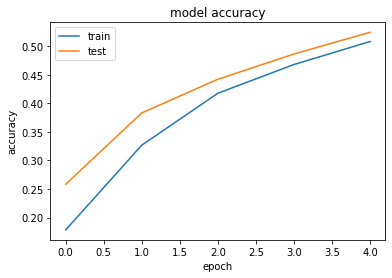

In [15]:
import matplotlib.pyplot as plt

plt.plot(epoch_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

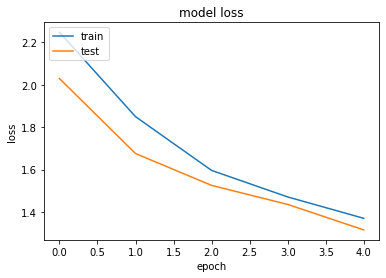

In [16]:
plt.plot(epoch_loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prueba del modelo

data = iter(test_loader)
images, labels = data.next()
show_image(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
for i, data in enumerate(test_loader, 0):
    X, Y = data
    X = X.to(device)
    Y = Y.to(device)    
    pred = net(X)
    loss = loss_function(pred, Y)    
    # running_loss += loss.item()
    # avg_loss = running_loss/(i + 1)
    probs = F.softmax(pred, 1)
    label = torch.argmax(probs, dim=1)
    correct = torch.sum(label == Y).item()
    total = Y.shape[0]
    acc = correct/total

In [18]:
print('accuracy: {}, loss: {}'.format(acc, loss))

accuracy: 0.5179, loss: 1.3407162427902222


## ¿Pytorch, el framework del futuro?

Muchos autores han sugerido que Pytorch es el framework del futuro, en lo personal, no se si es del futuro o representa un gran salto de los otros frameworks. A lo largo de este notebook expusimos varias ventajas del framework, notamos que simplifica muchas tareas que en otros frameworks como Keras eran muy repetitvos. La codifiación y uso de redes neuronales en Pytorch muestra de forma más explicita el uso de graficas computacionales, así como el proceso de backpropagation es más claro. 

Si bien la codificación no es tan simple como en Keras, es cierto que escribir código con Pytorch resulta muy Pytonico  y tiene muy buena integración con otras bibliotecas como veremos más adelante en *oxflower_pytorch.ipynb*.

Las ventajas computacionales sobre otros frameworks y características que podemos mencionar son las siguientes:

* Según los resultados del estudio [Deep Learning Frameworks Speed Comparison](https://wrosinski.github.io/deep-learning-frameworks/), se encontro que Pytorch resulto más rápido en varias tareas que Tensorflow. Se comparo el desempeño a partir de la implementación de varios modelos.

* Uno de los razgos principales de Pytorch es el llamadao *declarative data parallelism*. Esto permite usar ``Pytorch.nn.DataParallel`` que puede envolver cualquier módulo. Esto permite hacer paralelizble el entrenamiento y hacer uso de varios GPUs.

![Comparación de velocidad con Keras y Tensorflow](CIFAR10_pytorch/Comparison.png)


## Guardar el modelo

In [20]:
torch.save(net.state_dict(), 'CIFAR10_pytorch/model/net.json') 